In [1]:
import warnings
warnings.filterwarnings('ignore')


# Let's try out making some beta radar plots
from lsst.sims.maf.runComparison import RunComparison
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import glob

In [2]:
# Starting with example at
# https://matplotlib.org/examples/api/radar_chart.html

from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2
    
    # FFS, need to make sure we don't go over 360
    theta = theta % (2.*np.pi)

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

In [3]:
run_dirs = glob.glob('../potential_schedulers/sci*')
run_names = [direc.replace('../potential_schedulers/','').replace('sci_','').replace('v1.5_10yrs', '') for direc in run_dirs]


In [4]:
ack = []
for name in run_names:
    if name[-1] == '_':
        ack.append(name[:-1])
    else:
        ack.append(name)
run_names =ack

glance_dirs = glob.glob('../potential_schedulers/*10yrs.db')
glance_dirs = [filename.replace('.db', '') for filename in glance_dirs]

In [5]:
run_names

['ddf_heavy',
 'dm_heavy',
 'baseline_nexp2',
 'barebones',
 'baseline_nexp1',
 'rolling_exgal_mod2_dust_sdf_0.20',
 'mw_heavy',
 'ss_heavy']

In [6]:
dfs = []
for i in range(len(run_dirs)):
    ack = RunComparison('.', [run_names[i]], rundirs=[run_dirs[i]])
    ack.addSummaryStats()
    dfs.append(ack.summaryStats)
    #
    #df1 = ack.summaryStats.copy()
    ack.close()
    #ack = RunComparison('.', [run_names[i]], rundirs=[glance_dirs[i]])
    #ack.addSummaryStats()
    #df2 = ack.summaryStats
    #dfs.append(pd.concat([df1, df2], axis=1, join='inner'))
    #ack.close()
df = pd.concat(dfs)

In [7]:
df

,95th Percentile Parallax Error Parallax Error @ 22.4 All visits HealpixSlicer,95th Percentile Parallax Error Parallax Error @ 24.0 All visits HealpixSlicer,95th Percentile Proper Motion Error Proper Motion Error @ 20.5 All visits HealpixSlicer,95th Percentile Proper Motion Error Proper Motion Error @ 24.0 All visits HealpixSlicer,Area (sq deg) RapidRevisits All visits HealpixSlicer,DD:290 SNIa_Detected UserPointsSlicer,DD:290 SNIa_Nobs UserPointsSlicer,DD:290 SNIa_PrePeak UserPointsSlicer,DD:290 SNIa_WellSampled UserPointsSlicer,"DD:290, g UserPointsSlicer",...,YearCoverage night r HealpixSlicer,YearCoverage night u HealpixSlicer,YearCoverage night y HealpixSlicer,YearCoverage night z HealpixSlicer,fOArea fO All visits HealpixSlicer,fOArea/benchmark fO All visits HealpixSlicer,fONv MedianNvis fO All visits HealpixSlicer,fONv MinNvis fO All visits HealpixSlicer,fONv/benchmark MedianNvis fO All visits HealpixSlicer,fONv/benchmark MinNvis fO All visits HealpixSlicer
ddf_heavy,11.772347,50.183759,0.403864,6.220170,27192.844757,0.99100,43.61475,0.22275,0.20550,26.638878,...,10.0,10.0,10.0,10.0,18101.885340,1.005660,904.0,835.0,1.095758,1.012121
dm_heavy,10.618080,45.347677,0.394699,6.112602,27473.284965,0.98675,45.08150,0.22550,0.24450,26.665353,...,10.0,10.0,10.0,10.0,18169.028832,1.009390,949.0,881.0,1.150303,1.067879
baseline_nexp2,11.831710,50.432812,0.407503,6.108285,26547.958316,0.98825,42.23900,0.22075,0.19325,26.663045,...,10.0,10.0,10.0,10.0,17383.449980,0.965747,872.0,805.0,1.056970,0.975758
barebones,3.968692,16.234931,0.186791,2.508893,37642.574976,0.84225,46.43375,0.03175,0.23675,26.606204,...,10.0,10.0,10.0,10.0,18499.710528,1.027762,1122.0,1043.0,1.360000,1.264242
baseline_nexp1,11.118741,47.081131,0.396351,5.997404,27373.744103,0.98700,45.08275,0.22275,0.21400,26.622662,...,10.0,10.0,10.0,10.0,18173.225300,1.009624,944.0,875.0,1.144242,1.060606
rolling_exgal_mod2_dust_sdf_0.20,9.574528,40.953559,0.344168,5.196955,27277.413160,1.00000,69.79575,0.31325,0.34550,26.720269,...,10.0,10.0,10.0,10.0,17819.043381,0.989947,911.0,795.0,1.104242,0.963636
mw_heavy,11.202673,47.852974,0.395488,6.000396,28330.087666,0.99000,44.15700,0.22825,0.20875,26.689152,...,10.0,10.0,10.0,10.0,18814.445645,1.045247,920.0,872.0,1.115152,1.056970
ss_heavy,123.661977,539.728032,4.530070,112.879375,30306.420190,0.98750,42.95050,0.21900,0.19925,26.612185,...,10.0,10.0,10.0,10.0,18975.590025,1.054199,889.0,846.0,1.077576,1.025455


In [8]:
df['TDEsAsciiMetric  HealpixSlicer']

ddf_heavy                           8117.0
dm_heavy                            8117.0
baseline_nexp2                      8117.0
barebones                           5963.0
baseline_nexp1                      8117.0
rolling_exgal_mod2_dust_sdf_0.20    8383.0
mw_heavy                            8117.0
ss_heavy                            9309.0
Name: TDEsAsciiMetric  HealpixSlicer, dtype: float64

In [9]:
cols_dict= {'fO': 'fONv/benchmark MedianNvis fO All visits HealpixSlicer',
          'Proper Motion': 'Median Proper Motion Error (WFD) Proper Motion Error @ 24.0 All visits HealpixSlicer',
          'N Gals': 'N Galaxies (all) GalaxyCountsMetric_extended i HealpixSlicer',
          'SNe Ia': 'SNIa_PrePeak  UserPointsSlicer',
            'TDE': 'TDEsAsciiMetric  HealpixSlicer' # I think this isobservations of them
          }

In [18]:
sub_df = df[list(cols_dict.values())]
sub_df

,fONv/benchmark MedianNvis fO All visits HealpixSlicer,Median Proper Motion Error (WFD) Proper Motion Error @ 24.0 All visits HealpixSlicer,N Galaxies (all) GalaxyCountsMetric_extended i HealpixSlicer,SNIa_PrePeak UserPointsSlicer,TDEsAsciiMetric HealpixSlicer
ddf_heavy,1.095758,2.101540,1.181162e+10,0.16350,8117.0
dm_heavy,1.150303,2.208035,1.206574e+10,0.17050,8117.0
baseline_nexp2,1.056970,2.096306,1.178951e+10,0.15750,8117.0
barebones,1.360000,1.860636,1.099271e+10,0.03650,5963.0
baseline_nexp1,1.144242,2.025223,1.208061e+10,0.16950,8117.0
rolling_exgal_mod2_dust_sdf_0.20,1.104242,2.237154,1.216644e+10,0.15650,8383.0
mw_heavy,1.115152,2.046244,1.205900e+10,0.17075,8117.0
ss_heavy,1.077576,2.093914,1.216792e+10,0.17075,9309.0


In [19]:
df['fONv/benchmark MedianNvis fO All visits HealpixSlicer']

ddf_heavy                           1.095758
dm_heavy                            1.150303
baseline_nexp2                      1.056970
barebones                           1.360000
baseline_nexp1                      1.144242
rolling_exgal_mod2_dust_sdf_0.20    1.104242
mw_heavy                            1.115152
ss_heavy                            1.077576
Name: fONv/benchmark MedianNvis fO All visits HealpixSlicer, dtype: float64

In [21]:
# Let's normalize everything and reverse proper motion error so bigger is better

sub_df[cols_dict['Proper Motion']] = 1- (sub_df[cols_dict['Proper Motion']] - sub_df[cols_dict['Proper Motion']]['baseline_nexp1']) / sub_df[cols_dict['Proper Motion']]['baseline_nexp1']

for key in ['N Gals', 'SNe Ia', 'TDE', 'fO']:
    sub_df[cols_dict[key]] = sub_df[cols_dict[key]]/sub_df[cols_dict[key]]['baseline_nexp1']
sub_df

,fONv/benchmark MedianNvis fO All visits HealpixSlicer,Median Proper Motion Error (WFD) Proper Motion Error @ 24.0 All visits HealpixSlicer,N Galaxies (all) GalaxyCountsMetric_extended i HealpixSlicer,SNIa_PrePeak UserPointsSlicer,TDEsAsciiMetric HealpixSlicer
ddf_heavy,0.957627,0.962317,0.977733,0.964602,1.000000
dm_heavy,1.005297,0.909733,0.998769,1.005900,1.000000
baseline_nexp2,0.923729,0.964902,0.975904,0.929204,1.000000
barebones,1.188559,1.081269,0.909946,0.215339,0.734631
baseline_nexp1,1.000000,1.000000,1.000000,1.000000,1.000000
rolling_exgal_mod2_dust_sdf_0.20,0.965042,0.895354,1.007105,0.923304,1.032771
mw_heavy,0.974576,0.989621,0.998211,1.007375,1.000000
ss_heavy,0.941737,0.966083,1.007227,1.007375,1.146852


In [22]:
metric_names = list(cols_dict.keys())
theta = radar_factory(len(metric_names), frame='polygon')

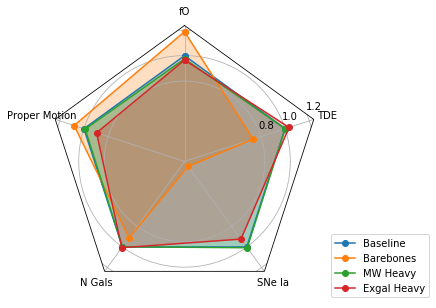

In [23]:
fig, axes = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))
axes.set_rgrids([0.8, 1.0, 1.2, 1.5])

data = sub_df.loc['baseline_nexp1', :]
axes.plot(theta, data, 'o-', label='Baseline')
axes.fill(theta, data, alpha=0.25, label='')

data = sub_df.loc['barebones', :]
axes.plot(theta, data, 'o-', label='Barebones')
axes.fill(theta, data, alpha=0.25, label='')

data = sub_df.loc['mw_heavy', :]
axes.plot(theta, data, 'o-', label='MW Heavy')
axes.fill(theta, data, alpha=0.25, label='')

data = sub_df.loc['rolling_exgal_mod2_dust_sdf_0.20', :]
axes.plot(theta, data, 'o-', label='Exgal Heavy')
axes.fill(theta, data, alpha=0.25, label='')


axes.set_varlabels(metric_names)
axes.legend(loc=(1.04,0))